# Setup

Let's import and initialize Spark, along with all the other libraries we're using (this might take a while).

In [1]:
# Uncomment these if do this homework locally
# Do not run this if you are on hive
# from local_install import setup_environment
# setup_environment()

import folium
import pyspark
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import numpy as np
import os
%pylab inline
%pylab notebook

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


In [2]:
sc = pyspark.SparkContext()
sql = pyspark.sql.SQLContext(sc)

# 1. DataFrames

## 1a. File Format Wrangling

Implement the loading of data files into DataFrame objects.

### Begin Student Code Here

In [3]:
root_path = "/home/ff/cs186/sp16/fec_2016_3_25"

# file_struct objects
com_file = {'header': "cm_header_file.csv", 'data': "cm.txt" }
can_file = {'header': "cn_header_file.csv", 'data': "cn.txt" }
com_can_link_file = {'header': "ccl_header_file.csv", 'data': "ccl.txt" }
indv_file = {'header': "indiv_header_file.csv", 'data': "itcont.txt" }
pas_file = {'header': "pas2_header_file.csv", 'data': "itpas2.txt" }
com_links_file = {'header': "oth_header_file.csv", 'data': "itoth.txt" }

def load_header(filename):
    """
    Given a header .csv file, return a list containing the names of all columns in the table.
    
    Input:
    filename: a string specifying the header .csv file to load
    
    Output:
    A list containing column names of the table
    """
    with open(filename, "r") as f:
        return [r.replace('\r\n','') for r in f.readline().split(",")]
    
def load_dataframe(file_struct):
    """
    Given a dictionary representing the locations of FEC raw files corresponding to a table,
    load the tables into a Spark DataFrame.
    
    Input:
    file_struct: a dictionary containing the keys 'header' and 'data', where
     'header' contains the name of the `.csv` file specifying the table header file, and
     'data' contains the name of the `.txt` file specifying the table data file
     
    Output:
    A DataFrame which contains the loaded data.
    """
    df = None
    
    # TODO
    # Okay, following the SparkSQL documentation for how to specify schema.
    
    data = sc.textFile(root_path + "/" + file_struct['data']) \
            .map(lambda l: l.split("|"))
        
    schema_string = load_header(root_path + "/" + file_struct['header'])
    
    # I'm guessing everything is a string. 
    fields = [StructField(field_name, StringType(), True) for field_name in schema_string]
    schema = StructType(fields)
    
    df = sql.createDataFrame(data, schema)
    
    
    
    return df.cache()

### End Student Code Here

We'll load these files into Spark now, and register them as temporary SQL tables.

In [4]:
com = load_dataframe(com_file)
can = load_dataframe(can_file)
links = load_dataframe(com_can_link_file)
indv = load_dataframe(indv_file)
pas = load_dataframe(pas_file)
com_links = load_dataframe(com_links_file)

In [5]:
com.registerTempTable("com")
can.registerTempTable("can")
links.registerTempTable("links")
indv.registerTempTable("indv")
pas.registerTempTable("pas")
com_links.registerTempTable("com_links")

## 1b. Basic Analytics Queries

As a demonstration, let's query for information corresponding to the strings "Clinton", "Sanders", "Trump", and "Cruz". Try these queries. How does this output look?

In [6]:
front_runners = can.where(can.CAND_NAME.like("%CLINTON%") | can.CAND_NAME.like("%SANDERS%") 
          | can.CAND_NAME.like("%TRUMP%") | can.CAND_NAME.like("%CRUZ%") )\
    .select("CAND_ID", "CAND_NAME", "CAND_STATUS", "CAND_OFFICE")
front_runners.show(truncate=False)

+---------+-----------------------------------+-----------+-----------+
|CAND_ID  |CAND_NAME                          |CAND_STATUS|CAND_OFFICE|
+---------+-----------------------------------+-----------+-----------+
|H2CA24153|THAYNE, DAVID CRUZ                 |P          |H          |
|H2MI08105|HETRICK, BRIAN CLINTON             |N          |H          |
|H2TX33123|SANDERS, KENNETH                   |P          |H          |
|H6NY05051|SANDERS, JAMES JR                  |C          |H          |
|H6NY09137|SANDERS, JAIME                     |N          |H          |
|H8OH02041|SANDERS, CHARLES W                 |P          |H          |
|P00003392|CLINTON, HILLARY RODHAM            |C          |P          |
|P60006111|CRUZ, RAFAEL EDWARD "TED"          |C          |P          |
|P60007168|SANDERS, BERNARD                   |C          |P          |
|P60012184|BALLSACK, DONALD TRUMP'S HAIRY KING|N          |P          |
|P60012333|CLINTON, BILL                      |N          |P    

In [7]:
front_runners = sql.sql("""
SELECT CAND_ID, CAND_NAME, CAND_STATUS, CAND_OFFICE
FROM can
WHERE CAND_NAME LIKE "%CLINTON%"
OR CAND_NAME LIKE "%SANDERS%"
OR CAND_NAME LIKE "%TRUMP%"
OR CAND_NAME LIKE "%CRUZ%"
""")
front_runners.registerTempTable("fr")
front_runners.show(truncate=False)

+---------+-----------------------------------+-----------+-----------+
|CAND_ID  |CAND_NAME                          |CAND_STATUS|CAND_OFFICE|
+---------+-----------------------------------+-----------+-----------+
|H2CA24153|THAYNE, DAVID CRUZ                 |P          |H          |
|H2MI08105|HETRICK, BRIAN CLINTON             |N          |H          |
|H2TX33123|SANDERS, KENNETH                   |P          |H          |
|H6NY05051|SANDERS, JAMES JR                  |C          |H          |
|H6NY09137|SANDERS, JAIME                     |N          |H          |
|H8OH02041|SANDERS, CHARLES W                 |P          |H          |
|P00003392|CLINTON, HILLARY RODHAM            |C          |P          |
|P60006111|CRUZ, RAFAEL EDWARD "TED"          |C          |P          |
|P60007168|SANDERS, BERNARD                   |C          |P          |
|P60012184|BALLSACK, DONALD TRUMP'S HAIRY KING|N          |P          |
|P60012333|CLINTON, BILL                      |N          |P    

That didn't work out so well. But notice how both queries got the same results! For the rest of the questions, you are allowed to write the queries in either form. Use the DataFrames that you created in part 1a. They are listed again here for reference:

* **com** contains committee information [Details](http://www.fec.gov/finance/disclosure/metadata/DataDictionaryCommitteeMaster.shtml)
* **can** contains candidate information [Details](http://www.fec.gov/finance/disclosure/metadata/DataDictionaryCandidateMaster.shtml)
* **links** contains linkage between committees and candidates [Details](http://www.fec.gov/finance/disclosure/metadata/DataDictionaryCandCmteLinkage.shtml)
* **indv** contains individual contributions to committees [Details](http://www.fec.gov/finance/disclosure/metadata/DataDictionaryContributionsbyIndividuals.shtml)
* **pas** contains contributions between committees [Details](http://www.fec.gov/finance/disclosure/metadata/DataDictionaryContributionstoCandidates.shtml)
* **com_links** links between committees [Details](http://www.fec.gov/finance/disclosure/metadata/DataDictionaryCommitteetoCommittee.shtml)

### Begin Student Code Here

Q1.

In [8]:
front_runners = None
# TODO

front_runners = can.where(can.CAND_NAME.like("%CLINTON%") | can.CAND_NAME.like("%SANDERS%") 
          | can.CAND_NAME.like("%TRUMP%") | can.CAND_NAME.like("%CRUZ%")) \
        .where(can.CAND_STATUS == "C") \
        .where(can.CAND_OFFICE == "P")

q1 = front_runners.select("CAND_ID", "CAND_NAME", "CAND_PCC")
q1.show(truncate=False)

+---------+-------------------------+---------+
|CAND_ID  |CAND_NAME                |CAND_PCC |
+---------+-------------------------+---------+
|P00003392|CLINTON, HILLARY RODHAM  |C00575795|
|P60006111|CRUZ, RAFAEL EDWARD "TED"|C00574624|
|P60007168|SANDERS, BERNARD         |C00577130|
|P80001571|TRUMP, DONALD J          |C00580100|
+---------+-------------------------+---------+



Q2.

In [9]:
num_indv_contributions = None
# TODO

front_runners.registerTempTable("front_runners")

num_indv_contributions = sql.sql("""
SELECT CAND_ID, CAND_NAME, COUNT(*) AS count
FROM front_runners, indv
WHERE front_runners.CAND_PCC = indv.CMTE_ID
GROUP BY CAND_ID, CAND_NAME
""")


q2 = num_indv_contributions.select("CAND_ID", "CAND_NAME", "count")
q2.show(truncate=False)

+---------+-------------------------+-----+
|CAND_ID  |CAND_NAME                |count|
+---------+-------------------------+-----+
|P80001571|TRUMP, DONALD J          |3006 |
|P60006111|CRUZ, RAFAEL EDWARD "TED"|34699|
|P60007168|SANDERS, BERNARD         |34524|
|P00003392|CLINTON, HILLARY RODHAM  |71249|
+---------+-------------------------+-----+



Q3.

In [10]:
indv_contributions_amt = None
# TODO

# $$ only comes through principal campaign committee? Guess so. 
indv_contributions_amt = sql.sql("""
SELECT CAND_ID, CAND_NAME, SUM(TRANSACTION_AMT) AS count
FROM front_runners, indv
WHERE front_runners.CAND_PCC = indv.CMTE_ID
GROUP BY CAND_ID, CAND_NAME
""") \
    .withColumnRenamed("count", "sum(TRANSACTION_AMT)")
    

q3 = indv_contributions_amt.select("CAND_ID", "CAND_NAME", "sum(TRANSACTION_AMT)")
q3.show(truncate=False)

+---------+-------------------------+--------------------+
|CAND_ID  |CAND_NAME                |sum(TRANSACTION_AMT)|
+---------+-------------------------+--------------------+
|P80001571|TRUMP, DONALD J          |1994976.0           |
|P60006111|CRUZ, RAFAEL EDWARD "TED"|2.4785175E7         |
|P60007168|SANDERS, BERNARD         |4.9001141E7         |
|P00003392|CLINTON, HILLARY RODHAM  |9.5996062E7         |
+---------+-------------------------+--------------------+



Q4.

In [11]:
linked_committees = None
# TODO

linked_committees = sql.sql("""
SELECT front_runners.CAND_NAME, front_runners.CAND_ID, com.CMTE_ID, com.CMTE_NM 
FROM front_runners, links, com
WHERE front_runners.CAND_ID = links.CAND_ID 
    AND links.CMTE_ID = com.CMTE_ID
""")
linked_committees.registerTempTable("linked_committees")

q4 = linked_committees.select("CAND_NAME", "CAND_ID", "CMTE_ID", "CMTE_NM")
q4.show(truncate=False)

+-------------------------+---------+---------+-------------------------------------------------------------------------------+
|CAND_NAME                |CAND_ID  |CMTE_ID  |CMTE_NM                                                                        |
+-------------------------+---------+---------+-------------------------------------------------------------------------------+
|CLINTON, HILLARY RODHAM  |P00003392|C00577395|PEOPLE IN COMMAND/PIC                                                          |
|SANDERS, BERNARD         |P60007168|C00590646|NEW YORK CAPITAL REGION FOR BRINGING ECONOMIC REVOLUTION NOW INSPIRING EVERYONE|
|SANDERS, BERNARD         |P60007168|C00612549|LORAIN COUNTY FORWARD                                                          |
|CLINTON, HILLARY RODHAM  |P00003392|C00575795|HILLARY FOR AMERICA                                                            |
|SANDERS, BERNARD         |P60007168|C00587766|SILVER CITY NM FOR BERNIE SANDERS                        

Q5.

In [12]:
num_com_contributions = None
# TODO

num_com_contributions = sql.sql("""
SELECT front_runners.CAND_NAME, COUNT(pas.CMTE_ID) as count
FROM front_runners, pas
WHERE front_runners.CAND_ID = pas.CAND_ID
GROUP BY CAND_NAME
""")

q5 = num_com_contributions.select("CAND_NAME", "count")
q5.show(truncate=False)

+-------------------------+-----+
|CAND_NAME                |count|
+-------------------------+-----+
|CLINTON, HILLARY RODHAM  |2561 |
|SANDERS, BERNARD         |1577 |
|TRUMP, DONALD J          |333  |
|CRUZ, RAFAEL EDWARD "TED"|643  |
+-------------------------+-----+



Q6.

In [13]:
com_contributions_amt = None
# TODO

com_contributions_amt = sql.sql("""
SELECT front_runners.CAND_NAME, SUM(TRANSACTION_AMT) as sum 
FROM front_runners, pas
WHERE front_runners.CAND_ID = pas.CAND_ID
GROUP BY front_runners.CAND_NAME
""") \
.withColumnRenamed("sum", "sum(TRANSACTION_AMT)")


q6 = com_contributions_amt.select("CAND_NAME", "sum(TRANSACTION_AMT)")
q6.show(truncate=False)

+-------------------------+--------------------+
|CAND_NAME                |sum(TRANSACTION_AMT)|
+-------------------------+--------------------+
|CLINTON, HILLARY RODHAM  |6064499.0           |
|SANDERS, BERNARD         |1202034.0           |
|TRUMP, DONALD J          |6099777.0           |
|CRUZ, RAFAEL EDWARD "TED"|1.2145601E7         |
+-------------------------+--------------------+



### End Student Code Here

# 2. K-means Clustering

## Use Dataframe API to load some Toy Data

Load a parquet file as a DataFrame.

In [14]:
df = sql.read.parquet("toy_data")

Let's look at a few records:

In [15]:
df.show()

+-----------+----------+
|          x|         y|
+-----------+----------+
| -4.5707927| -5.282721|
|  -5.762503| -4.832158|
|   7.907721|  6.793022|
|  7.4408655| -6.601918|
| -4.2428184| -4.162871|
| -5.7853255| -6.807544|
| -1.0236621| -8.026325|
|  7.2840943| 3.8668985|
|   8.975831| 3.7539392|
|  -7.442753|-5.6001735|
|-0.49966902| 5.3444986|
| -6.0518875|-5.4773846|
|  5.3814564| -4.115461|
| -5.9022512| 5.2586646|
| -3.1684203|-3.8134186|
| -6.7108235| 4.2055697|
|   2.811219| 3.8392153|
| -4.1118946| -6.137164|
|  5.8211355|-3.9361012|
|   8.003084|-3.3388462|
+-----------+----------+
only showing top 20 rows



## Plotting the Toy Data

We'll first plot a sample of some toy data. Let's collect a sample of records,

In [16]:
sample = df.sample(False, 0.2)

project out the `x` and the `y` columns,

In [17]:
x_sample = sample.select('x').collect()
y_sample = sample.select('y').collect()

and plot the data.

<IPython.core.display.Javascript object>


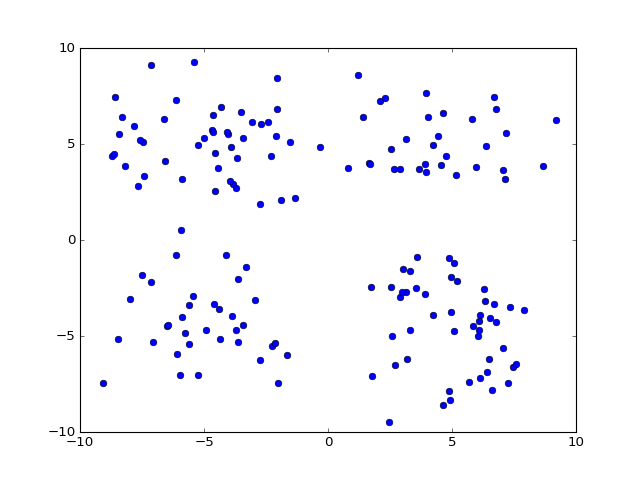

In [18]:
plt.figure()
plt.axis([-10, 10, -10, 10])
plot(x_sample, y_sample, 'bo')

## Implementation

Implement a distributed version of K-Means clustering using PySpark.

## 2a. K-Means++ Initialization

Initialize the centers using the K-Means++ Algorithm, using Distributed Reservoir Sampling. We've provided you the signatures of a few functions which may be helpful.

### Begin Student Code Here

In [19]:
def initialize_centers_plus(points, k):
    """
    Find k initial cluster centers using distributed weighted reservoir sampling.
    
    Inputs:
    points: a collection of d-dimensional points (x_1, x_2, ..., x_d).
    k: the number of cluster centers wanted
    
    Output:
    A list of k points which become the initial centers in K-means clustering
    """
    centers = []
    
    # Choose first center uniformly at random
    # TODO
    if type(points) is pyspark.rdd.RDD:
        centers.append(points.takeSample(False, 1, seed=0)[0])
    else: 
        centers.append(points.rdd.takeSample(False, 1, seed=0)[0])
    
    
    for _ in range(1, k):
        # Compute distances of each point to its nearest center, and
        # TODO
        
        # dpoints = elem is (point, distance to closest center)
        # dpoints = points.flatMap(lambda p: (p, nearest_center(centers, p)[1]))
        def distances(point):
            for pt in point:
                yield (pt, (nearest_center(centers, pt))[1])
        
        
        # given distances, choose a new center
        # TODO
        #HEEERRREEE 
        #centers.append(choose_partition_center(points.mapPartitions(distances)))
        #points.flatMap(distances) 
        
#         best_center = None
#         for center in points.flatMap(distances).mapPartitions(choose_partition_center):
#             best_center = pick_between_centers(center, best_center)
#         centers.append(best_center)
        
#         centers.append(points.flatMap(distances).mapPartitions(choose_partition_center) \
#                         .mapPartitions(pick_between_centers))

#         best_center = None
#         for center in points.flatMap(distances).mapPartitions(choose_partition_center).collect():
#             best_center = (pick_between_centers(center, best_center))
#         centers.append(best_center[0])
#         # Append only the center, but store all the info, for the later iterations
        
        best_center = points.mapPartitions(distances).mapPartitions(choose_partition_center) \
                            .reduce(pick_between_centers)
        centers.append(best_center[0]) # In the actual list, don't want the key. 
        
    return centers

In [20]:
def choose_partition_center(points_partition_iterator):
    """
    Choose a single center from a SINGLE PARTITION, using weighted random sampling.
    
    Inputs:
    points_partition_iterator: an iterator through a partition of D-dimensional points
    
    Output:
    (As an iterator) A 2-tuple, containing the randomly-chosen center and its weighted random-sampling key
    """
    center = None
    key = None
    # TODO
    
    # Maybe like, iterate through partition
    # Apply the weird r^thing thing
    # Then after all the iteration, do the choosing. 
    
    # Is points_partition_iterator a generator????? Generates the distances?? 
    # Generate the distances
    # Then the r^thing thing
    # Then choose?
    
    # OMFG
#     (center, key) = points_partition_iterator \
#          .flatMap(lambda p: (p[0], np.random.uniform(0, 1, size = 1)[0] ** (1/float(p[1] ** 2)))) \
#          .takeOrdered(1, key = lambda x: x[1])


        
    for p in points_partition_iterator:
        curr_key = 0
        if p[1] != 0:   
            curr_key = np.random.uniform(0, 1, size = 1)[0] ** (float(1)/(p[1] ** 2))
        if (key is None) or (curr_key > key):
            center = p[0]
            key = curr_key
            
    
#     # Optimize with numpy array
#     def key_func(tup):
#         return np.random.uniform(0, 1, size = 1)[0] ** (float(1) / (tup[1] ** 2))
    
#     vec_key_func = np.vectorize(key_func)
    
#     points = np.array(points_partition_iterator)
#     keys = vec_key_func(points)
#     # Need the largest one
#     idx_max = np.argmax(keys)
#     center = (points[idx_max])[0]
#     key = keys[idx_max]
    
        
        
    yield (center, key)

In [21]:
def pick_between_centers(candidate_center_1, candidate_center_2):
    """
    Between two centers from different partitions, pick the one with a larger key.
    
    Inputs:
    candidate_center_1: a 2-tuple, containing the randomly-chosen center and its weighted random sampling key 
                        from the first partition
    candidate_center_2: a 2-tuple, containing the randomly-chosen center and its weighted random sampling key 
                        from the first partition
    
    Output:
    A 2-tuple, containing the "better" center and its weighted random-sampling key
    """
    better_center = None
    # TODO
    #print("candidate_center_1 = " + str(candidate_center_1))
    #print("candidate_center_2 = " + str(candidate_center_2))
    if (candidate_center_2 is None) or (candidate_center_1[1] >= candidate_center_2[1]):
        better_center = candidate_center_1
    else:
        better_center = candidate_center_2
    
    #print("better_center = " + str(better_center))
    return better_center

In [22]:
def nearest_center(centers, point):
    """
    Given a point and a list of centers (also points), determine the center closest to that point,
    and compute the distance to that point.
    
    Inputs:
    centers: a list of points which represent the current centers
    point: the point to examine
    
    Outputs:
    A 2-tuple, containing the index of the closest center (point) and its distance from point
    """
    #(index, shortest_distance) = (None, None)
    # TODO
    
    
#     distances = []
#     for center in centers:
#         #print("center = " + str(center))
#         #print("point = " + str(point))
#         distances.append(np.linalg.norm(np.subtract(center, point)))
        
    # Optimize with numpy
    distances = np.linalg.norm(np.subtract(centers, point), axis = 1)
    shortest_distance = np.amin(distances)
    index = np.argmin(distances)
    
    
    return (index, shortest_distance)

### End Student Code Here

### Super simple test for nearest_center

In [23]:
centers = df.rdd.takeSample(False, 3, seed=0)
print(np.subtract(centers[0], centers[1]))
print("Centers = " + str(centers))

point = df.rdd.takeSample(False, 1, seed = 0)[0]
print("Test point = " + str(point))
print("# Dimensions of point = " + str(len(point)))

print("Result of nearest_center = " + str(nearest_center(centers, point)))

[ -1.0613699   12.84425116]
Centers = [Row(x=-4.381218910217285, y=5.878631591796875), Row(x=-3.3198490142822266, y=-6.9656195640563965), Row(x=5.281597137451172, y=3.2823495864868164)]
Test point = Row(x=6.618934631347656, y=3.686994791030884)
# Dimensions of point = 2
Result of nearest_center = (2, 1.39721484179844)


### Super simple test for choose_partition_center(points_partition_iterator)

In [24]:
def distances(point):
            yield (point, (nearest_center(centers, point))[1])

print(df.sample(False, 0.01, 0).collect())     
print('\n')
print(df.sample(False, 0.01, 0).flatMap(distances).collect())
print('\n')
print(df.sample(False, 0.01, 0).flatMap(distances).mapPartitions(choose_partition_center).collect())

[Row(x=-4.381218910217285, y=5.878631591796875), Row(x=-8.474529266357422, y=-6.686147212982178), Row(x=2.495199680328369, y=4.78023099899292), Row(x=5.716551780700684, y=1.6378464698791504), Row(x=-8.183769226074219, y=3.8455898761749268), Row(x=-3.727321147918701, y=-4.232320785522461), Row(x=-4.833417892456055, y=-3.2847752571105957), Row(x=5.976852893829346, y=-6.600379943847656), Row(x=5.704458236694336, y=6.465510368347168), Row(x=1.640343427658081, y=4.029616832733154)]


[(Row(x=-4.381218910217285, y=5.878631591796875), 0.0), (Row(x=-8.474529266357422, y=-6.686147212982178), 5.162250797486398), (Row(x=2.495199680328369, y=4.78023099899292), 3.1634885040081464), (Row(x=5.716551780700684, y=1.6378464698791504), 1.7010514519604152), (Row(x=-8.183769226074219, y=3.8455898761749268), 4.3119192388172927), (Row(x=-3.727321147918701, y=-4.232320785522461), 2.7635042522900819), (Row(x=-4.833417892456055, y=-3.2847752571105957), 3.9798876316991278), (Row(x=5.976852893829346, y=-6.6003799

### Super simple test for pick_between_centers(candidate_center_1, candidate_center_2)

In [25]:
candidates = df.sample(False, 0.01, 0).flatMap(distances).mapPartitions(choose_partition_center).collect()
print(candidates)
print('\n')
print(pick_between_centers(candidates[0], candidates[1]))

[(Row(x=-4.381218910217285, y=5.878631591796875), 0), (Row(x=2.495199680328369, y=4.78023099899292), 0.98984070127479529), (Row(x=-4.833417892456055, y=-3.2847752571105957), 0.98892434126137108), (Row(x=5.976852893829346, y=-6.600379943847656), 0.9945548050828511)]


(Row(x=2.495199680328369, y=4.78023099899292), 0.98984070127479529)


In [26]:
best_center = None 
for cand in candidates:
    best_center = pick_between_centers(cand, best_center)
    print(best_center)
print("best_center = " + str(best_center))

(Row(x=-4.381218910217285, y=5.878631591796875), 0)
(Row(x=2.495199680328369, y=4.78023099899292), 0.98984070127479529)
(Row(x=2.495199680328369, y=4.78023099899292), 0.98984070127479529)
(Row(x=5.976852893829346, y=-6.600379943847656), 0.9945548050828511)
best_center = (Row(x=5.976852893829346, y=-6.600379943847656), 0.9945548050828511)


In [27]:
list_of_centers = []
print(candidates)
print('\n')
for _ in range(1, 5):
        best_center = None
        for cand in candidates:
            #print("cand = " + str(cand))
            best_center = pick_between_centers(cand, best_center)
            #print("result = " + str(best_center))
            #print("Line 10, appending " + str(best_center[0]))
        list_of_centers.append(best_center[0])
        #print('\n')
        
print("list_of_centers = " + str(list_of_centers))

[(Row(x=-4.381218910217285, y=5.878631591796875), 0), (Row(x=2.495199680328369, y=4.78023099899292), 0.98984070127479529), (Row(x=-4.833417892456055, y=-3.2847752571105957), 0.98892434126137108), (Row(x=5.976852893829346, y=-6.600379943847656), 0.9945548050828511)]


list_of_centers = [Row(x=5.976852893829346, y=-6.600379943847656), Row(x=5.976852893829346, y=-6.600379943847656), Row(x=5.976852893829346, y=-6.600379943847656), Row(x=5.976852893829346, y=-6.600379943847656)]


## Plotting the centers

Let's see how our initialization algorithm performs. How do your centers look? Are they too close to each other?

[Row(x=6.618934631347656, y=3.686994791030884), Row(x=-2.9383933544158936, y=-3.1089415550231934), Row(x=6.7718377113342285, y=-4.285919666290283), Row(x=-3.098952293395996, y=4.684759140014648)]


<IPython.core.display.Javascript object>


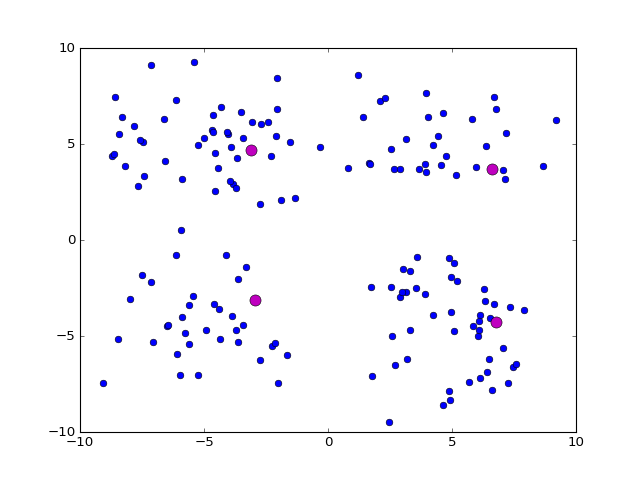

In [28]:
num_centers = 4
centers = initialize_centers_plus(df, num_centers)
print centers 

plt.figure()
plt.axis([-10, 10, -10, 10])
plot(x_sample, y_sample, 'bo')
centers = np.asarray(centers)
plt.plot(centers[:,0], centers[:,1], 'mo', markersize = 10)

## 2b. Main Loop

Now, implement the main loop in K-means clustering. Again, we've provided you the signatures of some functions which may be useful.

Note: The statistics of a new center "mean" is given by:
$$
\bar{x}_k = \frac{1}{n_k} \sum_{x \in \text{Cluster}[k]}^{n_i} x
$$
So the only statistics we require are $n_k$ the number of elements in cluster $k$ and $\sum_{x \in \text{Cluster}[k]}^{n_i} x$ the sum of the elements in cluster $k$.

### Begin Student Code Here

In [29]:
def k_means(points,
            k = num_centers,
            initial_centers = None,
            max_iterations = 100,
            initializer = initialize_centers_plus,
            epsilon = 0.001):
    """
    Executes the K-means algorithm on a collection of points.
    
    Inputs:
    points: a collection of d-dimensional points (x_1, x_2, ..., x_d).
    k: the number of cluster centers wanted
    initial_centers: if supplied, skips the initialization phase and uses points from this value
    max_iterations: the maximum number of main-loop iterations to run
    initializer: a function which selects initial centers (if none supplied)
    epsilon: the threshhold at which convergence is reached and the algorithm halted
    
    Output:
    A list of k candidate cluster centers
    """
    
    # speeds up rerunning
    points.cache()
    
    
    
    old_centers = None
    new_centers = None
    if initial_centers: # we were provided initial centers to use
        new_centers = initial_centers
    else: # we need to initialize the centers ourselves
        # TODO
        new_centers = initializer(points, k)

        
    iteration = 0
    while not has_converged(old_centers, new_centers, epsilon) and iteration < max_iterations:
        # update centers
        # TODO
        #print(iteration)
        #old_centers = new_centers[:]
        old_centers = new_centers
        
        
        # So compute statistics for new centers, computer_new_center_statistics. 
        # OMFG I HAVE NO IDEA HOW TO ACTUALLY DO THIS
        # Lambda function so can call compute_new_center_stats with 2 params wow 
        #print("line 47")
        agg_stats = points.mapPartitions(lambda iter: compute_new_center_statistics(iter, old_centers)) \
                    .reduce(add_statistics)
            
        #print("line 50")
        #print("agg_stats = " + str(agg_stats))
        #print(iteration)
        #print("agg_stats = " + str(agg_stats))
            
        counts = agg_stats[0]
        sums = agg_stats[1]
            
        new_centers = (np.divide(sums, counts[:, None])).tolist()
        #print("new_centers = " + str(new_centers))
        
        
        
        iteration += 1
        
    return new_centers

In [30]:
def compute_new_center_statistics(iterator, old_centers):
    """
    Given an iterator over points and a list of old centers, compute the statistics for the new center.
    
    Input:
    iterator: an iterator over points
    old_centers: a list of centers (points) from the previous iteration
    
    Output:
    A 2-tuple (counts, sums) consisting of:
     - counts: an array of length k containing the count of points in each new center
     - sums: a k by d array consisting of sum of the points assigned to each center
     
    Note that from the tuple you could compute the ith new center:
      sums[i] / counts[i]
    """
    # Get the shape of the old centers
    # TODO
    # Ohhhh need k & d. 
    
    #print("in compute_new_center_statistics")
    
    k = len(old_centers)
    d = len(old_centers[0])
    
    # Initialize the sums
    # TODO
#     counts = None
#     sums = None
    counts = np.zeros(k)
    sums = np.zeros([k, d])
    #sums = np.ndarray([k, d])
    
    # Loop over the data and compute the new assignments
    # TODO
    #for _ in []:
    for point in iterator:
        # print("HIIIII")
        # Compute the nearest center (you just implemented this!)
        # TODO
        center_idx = (nearest_center(old_centers, point))[0]
        
        # Update the sums and counts
        # TODO
        #counts[center_idx] += 1
        counts[center_idx] += 1
        sums[center_idx] += point
        

        
    yield (counts, sums)
    # So haven't yet, actually computed the new centers. 

In [31]:
def add_statistics(stats_1, stats_2):
    """
    Given statistics from two partitions, add those statistics.
    """
    #stats = (None, None)
    # Compute stats_1 + stats_2
    # TODO
    # Okay, apparently np.add returns the stuff like a column vector. 
    
    #print("stats_1 = " + str(stats_1))
    #print("stats_2 = " + str(stats_2))
#     print("\n")
    
    # np.add doesn't work with immutable tuples D: 
    # summation = np.add(stats_1, stats_2)
    # You're adding (counts, sums) from each though. 
    #print("in add_statistics")
    counts_agg = np.add(stats_1[0], stats_2[0])
    # sums_agg = stats_1[1] + stats_2[1]
    sums_agg = np.add(stats_1[1], stats_2[1])
        
        
    stats = (counts_agg, sums_agg)
    #print("stats = " + str(stats))
    return stats

### End Student Code Here

In [32]:
def has_converged(old_centers, new_centers, epsilon):
    """
    Test if the distance between the centers is less than epsilon.
    """
    #print("checking convergence")
    return (old_centers) and (new_centers) and \
        np.linalg.norm(np.asarray(old_centers) - np.asarray(new_centers), ord=2) < epsilon

### Testing compute_new_center_statistics(iterator, old_centers)

In [33]:
for i in range(2):
    print(i)
    centers = df.rdd.takeSample(False, 4, seed=i)
    print(centers)
    print(df.mapPartitions(lambda iter: compute_new_center_statistics(iter, centers)).collect())
    print('\n')

0
[Row(x=-0.3100571930408478, y=4.826961040496826), Row(x=5.303572654724121, y=7.972552299499512), Row(x=-4.119676113128662, y=4.0377197265625), Row(x=-3.3198490142822266, y=-6.9656195640563965)]
[(array([ 24.,  41.,  42.,  93.]), array([[  68.12611231,   57.64909196],
       [ 224.9038384 ,  221.6973772 ],
       [-208.28609633,  194.45297741],
       [ -72.43775816, -492.11138487]])), (array([ 24.,  40.,  53.,  83.]), array([[  44.25770882,   80.04621327],
       [ 218.85432124,  187.09532928],
       [-295.40485477,  224.11376971],
       [  -4.57332373, -438.52276146]])), (array([ 23.,  39.,  46.,  92.]), array([[  40.50841844,   67.70726952],
       [ 221.41820955,  204.00017649],
       [-239.11359739,  205.23878706],
       [ -18.22942871, -483.29175282]])), (array([ 28.,  41.,  51.,  80.]), array([[  71.89762525,   79.80518037],
       [ 232.89407897,  218.78540951],
       [-284.70346773,  254.78297216],
       [  14.08269215, -436.6984961 ]]))]


1
[Row(x=-5.051076412200928, 

### Testing add_statistics(stats_1, stats_2) 

In [34]:
# sample = (df.rdd.takeSample(False, 1, seed=0))[0]
# print(len(sample))
# print("sample = " + str(sample))
print(np.zeros([4, 2]))
print((df.sample(False, 0.01, 1)).count())
print("num parittions = " + str((df.sample(False, 0.01, 1)).rdd.getNumPartitions()))
def mapper(iterator):
    yield ([1, 1, 1, 1], 1)
print(df.sample(False, 0.01, 1).mapPartitions(mapper).reduce(add_statistics))

[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
10
num parittions = 4
(array([4, 4, 4, 4]), 4)


## Plotting Clusters

How does your code perform? Are these good clusters?

In [35]:
colors = ['ro', 'bo', 'go', 'yo'] # for now just use 4 colors

def plot_clusters(centers, plt):
    for i in range(num_centers):
        cluster = df.rdd.filter(lambda x: nearest_center(centers, x)[0] == i)
        cluster_sample = np.asarray(cluster.sample(False, 0.2).collect())
        plt.plot(cluster_sample[:,0], cluster_sample[:,1], colors[i])
    

<IPython.core.display.Javascript object>


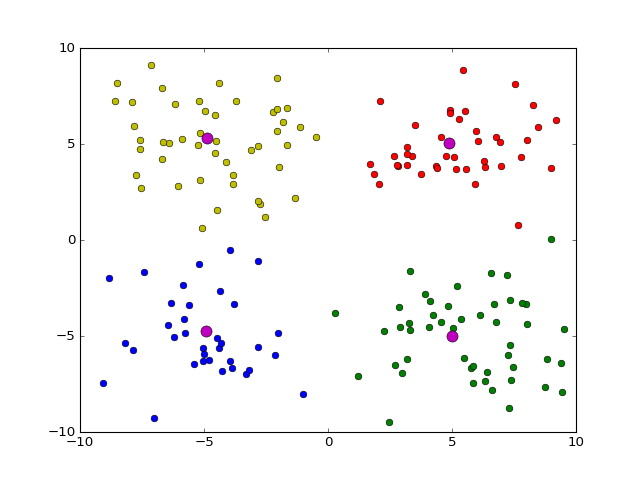

[[4.878010442304374, 5.056300238442065], [-4.9232175485722385, -4.759898136346484], [5.008285308902587, -4.97854467940016], [-4.8916124622731365, 5.305392692041634]]


In [36]:
plt.figure()
plt.axis([-10, 10, -10, 10])
cluster = df.rdd.filter(lambda x: nearest_center(centers, x)[0] == i)
centers = k_means(df, num_centers)
print(centers)
plot_clusters(centers, plt)

centers = np.asarray(centers)
plt.plot(centers[:,0], centers[:,1], 'mo', markersize = 10)


# 3. Geographical Contribution Clustering

Let's put everything together! First we'll load the required data files.

In [37]:
zip_codes = sql.read.parquet("zip_codes")

Now we'll grab the relevant data we need. We'll join the table of front runners we collected earlier with their contributors' zip codes to get latitudinal and longitudinal data...

In [38]:
contrib_zips = \
    front_runners.join(indv, front_runners.CAND_PCC == indv.CMTE_ID) \
    .select("CAND_NAME", "CAND_ID", "ZIP_CODE")
contrib_zips = contrib_zips.withColumn("SHORT_ZIP", contrib_zips.ZIP_CODE.substr(0,5))

In [39]:
contrib_locs = \
    contrib_zips.join(zip_codes, contrib_zips.SHORT_ZIP == zip_codes.zip) \
    .select("CAND_NAME", "latitude", "longitude").cache()

In [40]:
candidate_names = [x[0] for x in contrib_locs.select("CAND_NAME").distinct().collect()]
candidate_names

[u'CLINTON, HILLARY RODHAM',
 u'SANDERS, BERNARD',
 u'TRUMP, DONALD J',
 u'CRUZ, RAFAEL EDWARD "TED"']

In [41]:
X = {}
for candidate in candidate_names:
    X[candidate] = contrib_locs.where(contrib_locs.CAND_NAME == candidate) \
        .select("latitude", "longitude") \
        .map(lambda r: np.array([x for x in r])) \
        .coalesce(sc.defaultParallelism).cache()

...which will allow us to plot these locations.

In [42]:
maps = {}
for candidate in X:
    maps[candidate] = folium.Map(location=[40, -100],
           tiles='Stamen Toner',
           zoom_start=4)
    locs = X[candidate].sample(False, 0.01).collect()
    for l in locs:
        folium.Marker(l).add_to(maps[candidate])

In [43]:
maps[u'CRUZ, RAFAEL EDWARD "TED"']

We can run k-means for each candidate. What's a good value for $k$? Run the K-means algorithm you developed earlier with different values of $k$ to determine the best one.

### Begin Student Code Here

In [46]:
def compute_errors(candidate_locations, k_range):
    errors = {}
    for c in candidate_locations:
        errors[c] = []
        for k in k_range:
            # For each candidate, test multiple values of k
            # TODO
            # Error = sum of distances from points to cluster center
            
            
            
#             k_means(points, k, epsilon = 0.001) # outputs a list of k candidate cluster centers
            
#             nearest_center(centers, point) # output a tuple: index of the closest center (point) and dist
            
#             add_statistics(stats_1, stats_2)
            
#             points.mapPartitions(lambda iter: compute_new_center_statistics(iter, old_centers)) \
#                     .reduce(add_statistics)


            #print(type(candidate_locations[c]))
            #print(type(candidate_locations[c]) is pyspark.rdd.RDD)
            centers = k_means(candidate_locations[c], k, epsilon = 0.001)
            #print("centers = " + str(centers))
            
            #dist_agg = (candidate_locations[c]).mapPartitions(lambda point: nearest_center(centers, point)) \
                                    #.reduce(add_statistics)
            
            def distances(point):
                for pt in point:
                    yield (1, (nearest_center(centers, pt))[1])
                    # 1 to count the # points

            dist_agg = (candidate_locations[c]).mapPartitions(distances) \
                                                .reduce(add_statistics)
                
            #dist_agg = (candidate_locations[c]).mapPartitions(distances).reduce(add_statistics)

            #dist_agg = (candidate_locations[c]).map(lambda point: nearest_center(centers, point)) \
                                                #.reduce(add_statistics)
            
            # The actual distance is the 2nd entry though.
            
            # But want / by # points. 
            errors[c].append(dist_agg[1] / dist_agg[0])
            print("finished k = " + str(k) + " for candidate " + str(c))
            
        print("finished candidate " + str(c))
            
    return errors

<IPython.core.display.Javascript object>


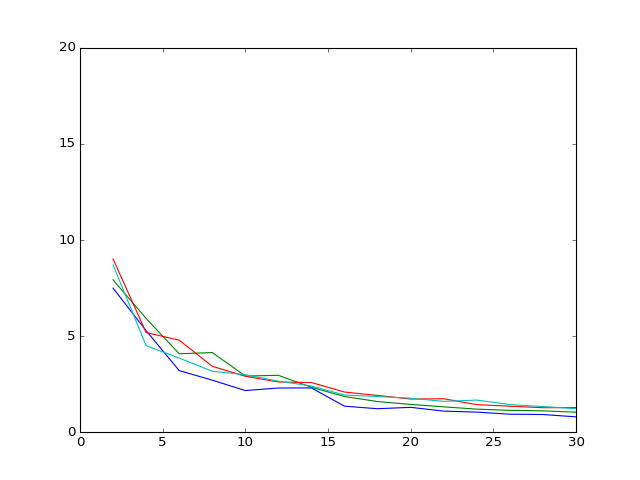

finished k = 2 for candidate CLINTON, HILLARY RODHAM
finished k = 4 for candidate CLINTON, HILLARY RODHAM
finished k = 6 for candidate CLINTON, HILLARY RODHAM
finished k = 8 for candidate CLINTON, HILLARY RODHAM
finished k = 10 for candidate CLINTON, HILLARY RODHAM
finished k = 12 for candidate CLINTON, HILLARY RODHAM
finished k = 14 for candidate CLINTON, HILLARY RODHAM
finished k = 16 for candidate CLINTON, HILLARY RODHAM
finished k = 18 for candidate CLINTON, HILLARY RODHAM
finished k = 20 for candidate CLINTON, HILLARY RODHAM
finished k = 22 for candidate CLINTON, HILLARY RODHAM
finished k = 24 for candidate CLINTON, HILLARY RODHAM
finished k = 26 for candidate CLINTON, HILLARY RODHAM
finished k = 28 for candidate CLINTON, HILLARY RODHAM
finished k = 30 for candidate CLINTON, HILLARY RODHAM
finished candidate CLINTON, HILLARY RODHAM
finished k = 2 for candidate SANDERS, BERNARD
finished k = 4 for candidate SANDERS, BERNARD
finished k = 6 for candidate SANDERS, BERNARD
finished k = 

In [47]:
plt.figure()
plt.axis([0, 30, 0, 20])
k_range = range(2, 32, 2)
#print(X)
#print(type(X))

errors = compute_errors(X, k_range)
for c in errors:
    plot(k_range, errors[c])
    

Now that you've found a suitable value for k, run K-means to compute the desired clusters.

In [48]:
centers = {}
k = 8 # TODO enter the value you found here
for c in X:
    # Find the cluster centers for each candidate
    # TODO
    centers[c] = k_means(X[c], k)

### End Student Code Here

At last, we have the clusters we want. Here's a nifty visualization.

In [51]:
colors = dict(zip(centers.keys(), ['blue', 'green','orange', 'red']))
centers_map = folium.Map(location=[40, -100],
                         zoom_start=4)
for candidate in centers: 
    locs = centers[candidate]
    for l in locs:
        folium.Marker(l,
                      popup=str(l),
                      icon=folium.Icon(color=colors[candidate])).add_to(centers_map)
centers_map

Congratulations! You've successfully implemented a scalable machine learning algorithm on dataset of campaign finance contributions!